In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
from collections import Counter
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

In [3]:
# ============================
# 나눔폰트 설정
# ============================
import matplotlib.font_manager as fm

plt.rcParams['font.family'] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

# 폰트 확인
try:
    available_fonts = [f.name for f in fm.fontManager.ttflist]
    if 'NanumGothic' in available_fonts:
        print("✅ 나눔폰트 설정 완료!")
    else:
        print("⚠️ 나눔폰트 미설치!")
        print("   터미널 실행: sudo apt-get install fonts-nanum")
        print("   설치 후 커널 재시작 필요")
except Exception as e:
    print(f"❌ 폰트 설정 오류: {e}")


✅ 나눔폰트 설정 완료!


In [4]:
# ============================
# 1. 데이터 로드
# ============================
train_df = pd.read_csv('train.csv')
meta_df = pd.read_csv('meta.csv')

print(f"학습 데이터: {len(train_df)}개")
print(f"클래스 수: {len(meta_df)}개")



학습 데이터: 1570개
클래스 수: 17개


In [5]:
# ============================
# 기본 정보
# ============================
print("\n" + "="*80)
print("📋 Train 데이터 기본 정보")
print("="*80)
print(train_df.head(10))
print(f"\n데이터 shape: {train_df.shape}")
print(f"결측치: {train_df.isnull().sum().sum()}개")

print("\n" + "="*80)
print("📋 Meta 데이터")
print("="*80)
print(meta_df)

# 클래스명 매핑
class_names = dict(zip(meta_df['target'], meta_df['class_name']))
print("\n클래스 매핑:")
for target, name in class_names.items():
    print(f"  {target}: {name}")



📋 Train 데이터 기본 정보
                     ID  target
0  002f99746285dfdd.jpg      16
1  008ccd231e1fea5d.jpg      10
2  008f5911bfda7695.jpg      10
3  009235e4c9c07af5.jpg       4
4  00b2f44967580c74.jpg      16
5  00cfa88ce8973dea.jpg       5
6  00ec594b7cc89183.jpg      15
7  00f59b12e9e08f29.jpg      16
8  00fdc02d9b552fe8.jpg      15
9  012913977fd1d980.jpg      14

데이터 shape: (1570, 2)
결측치: 0개

📋 Meta 데이터
    target                                         class_name
0        0                                     account_number
1        1  application_for_payment_of_pregnancy_medical_e...
2        2                                      car_dashboard
3        3            confirmation_of_admission_and_discharge
4        4                                          diagnosis
5        5                                     driver_lisence
6        6                              medical_bill_receipts
7        7                     medical_outpatient_certificate
8        8                   

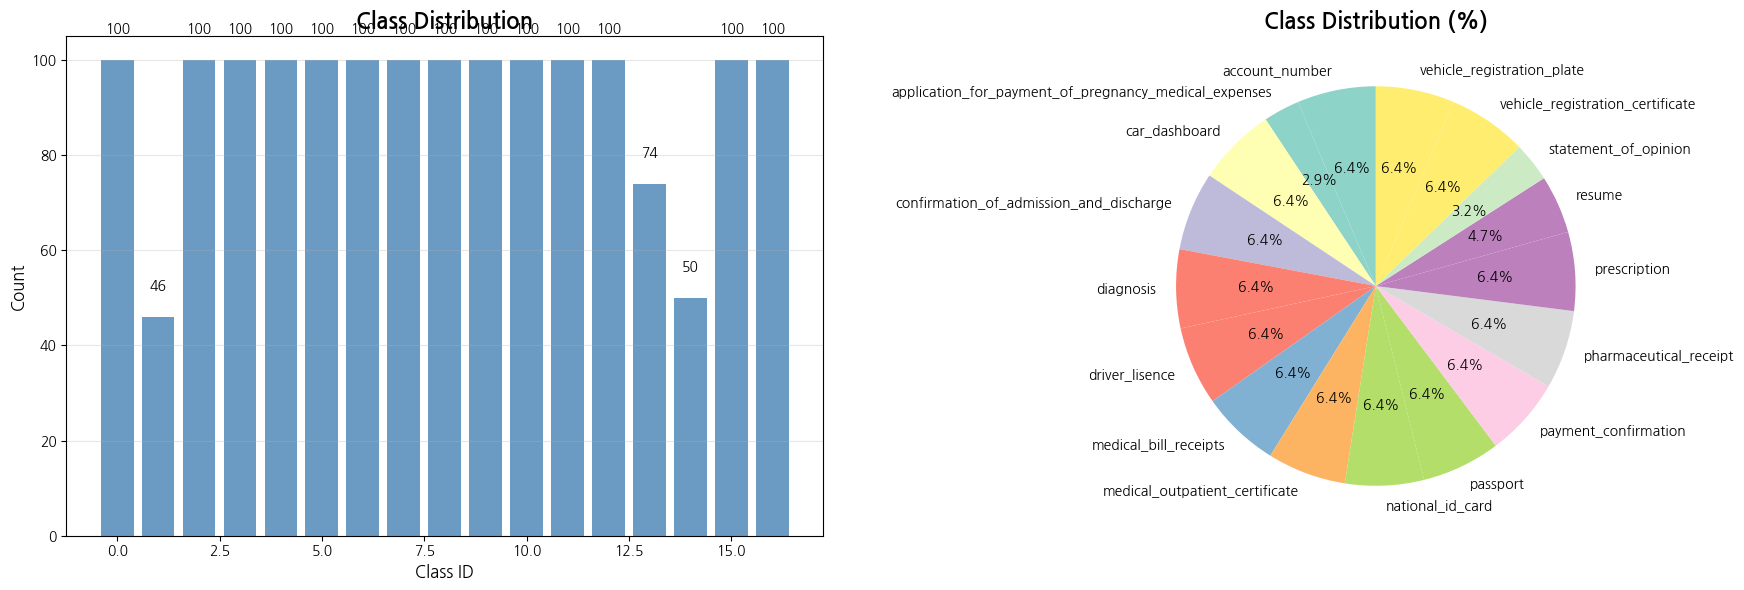

✅ eda_class_distribution.png


In [6]:
# ============================
# 클래스 분포
# ============================
class_counts = train_df['target'].value_counts().sort_index()

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Bar Chart
axes[0].bar(class_counts.index, class_counts.values, color='steelblue', alpha=0.8)
axes[0].set_title('Class Distribution', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Class ID', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(True, alpha=0.3, axis='y')

# 값 표시
for idx, count in zip(class_counts.index, class_counts.values):
    axes[0].text(idx, count + 5, str(count), ha='center', va='bottom', fontsize=10)

# Pie Chart
colors = plt.cm.Set3(np.linspace(0, 1, len(class_counts)))
axes[1].pie(class_counts.values, labels=[class_names[i] for i in class_counts.index], 
            autopct='%1.1f%%', colors=colors, startangle=90)
axes[1].set_title('Class Distribution (%)', fontsize=16, fontweight='bold')

plt.tight_layout()
#plt.savefig('eda_class_distribution.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ eda_class_distribution.png")


In [7]:
# ============================
# 불균형 클래스 분석
# ============================
print("\n" + "="*80)
print("⚠️ 클래스 불균형 분석")
print("="*80)

print(f"\n클래스별 샘플 수:")
for target in class_counts.index:
    count = class_counts[target]
    name = class_names[target]
    percentage = count / len(train_df) * 100
    
    status = "✅" if count >= 100 else "⚠️"
    print(f"{status} {target:2d}: {name:40s} - {count:3d}개 ({percentage:5.2f}%)")

# 100개 미만 클래스
minority_classes = class_counts[class_counts < 100]
print(f"\n📌 100개 미만 클래스: {len(minority_classes)}개")
for target in minority_classes.index:
    print(f"  - {class_names[target]}: {class_counts[target]}개")

# 통계
print(f"\n📊 통계:")
print(f"  - 평균: {class_counts.mean():.1f}개")
print(f"  - 중앙값: {class_counts.median():.1f}개")
print(f"  - 최소: {class_counts.min()}개")
print(f"  - 최대: {class_counts.max()}개")
print(f"  - 표준편차: {class_counts.std():.1f}")



⚠️ 클래스 불균형 분석

클래스별 샘플 수:
✅  0: account_number                           - 100개 ( 6.37%)
⚠️  1: application_for_payment_of_pregnancy_medical_expenses -  46개 ( 2.93%)
✅  2: car_dashboard                            - 100개 ( 6.37%)
✅  3: confirmation_of_admission_and_discharge  - 100개 ( 6.37%)
✅  4: diagnosis                                - 100개 ( 6.37%)
✅  5: driver_lisence                           - 100개 ( 6.37%)
✅  6: medical_bill_receipts                    - 100개 ( 6.37%)
✅  7: medical_outpatient_certificate           - 100개 ( 6.37%)
✅  8: national_id_card                         - 100개 ( 6.37%)
✅  9: passport                                 - 100개 ( 6.37%)
✅ 10: payment_confirmation                     - 100개 ( 6.37%)
✅ 11: pharmaceutical_receipt                   - 100개 ( 6.37%)
✅ 12: prescription                             - 100개 ( 6.37%)
⚠️ 13: resume                                   -  74개 ( 4.71%)
⚠️ 14: statement_of_opinion                     -  50개 ( 3.18%)
✅ 15: vehicl

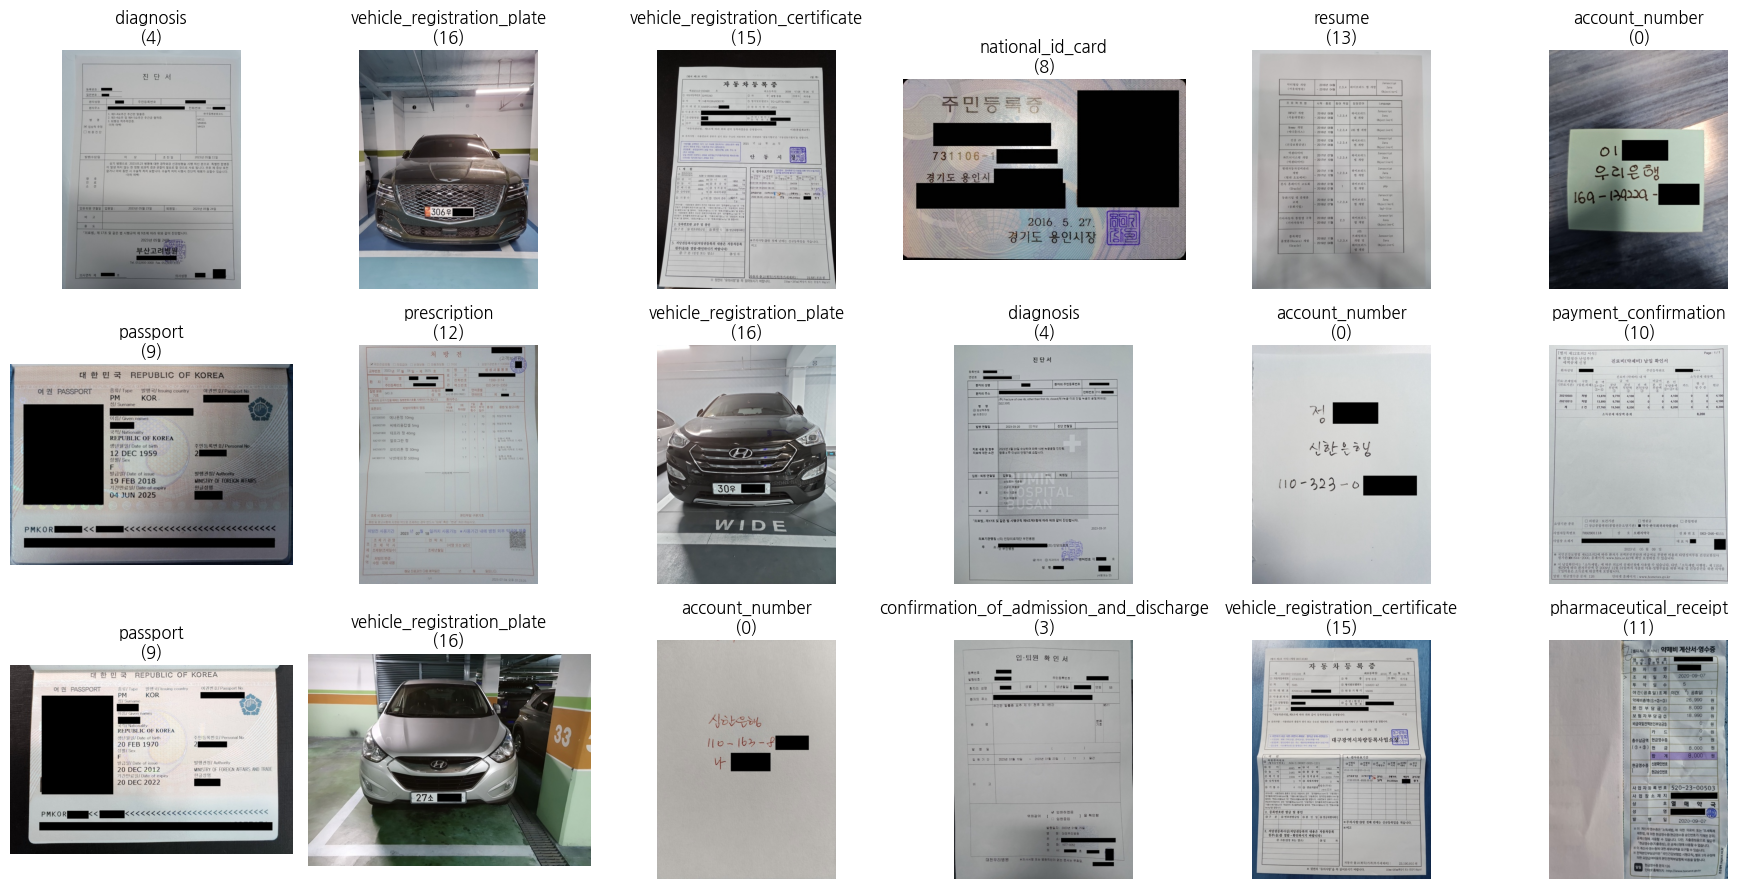

In [8]:
# ============================
# 4. 이미지 샘플 확인
# ============================
import cv2
import random

fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i, ax in enumerate(axes.flat):
    sample = train_df.sample(1).iloc[0]
    img = cv2.imread(f"train/{sample['ID']}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    class_name = meta_df[meta_df['target'] == sample['target']]['class_name'].values[0]
    ax.imshow(img)
    ax.set_title(f"{class_name}\n({sample['target']})")
    ax.axis('off')

plt.tight_layout()
#plt.savefig('sample_images.png')
plt.show()




📐 이미지 크기 분석 (샘플 200개)


이미지 크기 확인: 100%|██████████| 200/200 [00:00<00:00, 887.45it/s]



높이:
  - 최소: 348px
  - 최대: 612px
  - 평균: 544px
  - 중앙값: 591px

너비:
  - 최소: 428px
  - 최대: 753px
  - 평균: 492px
  - 중앙값: 443px


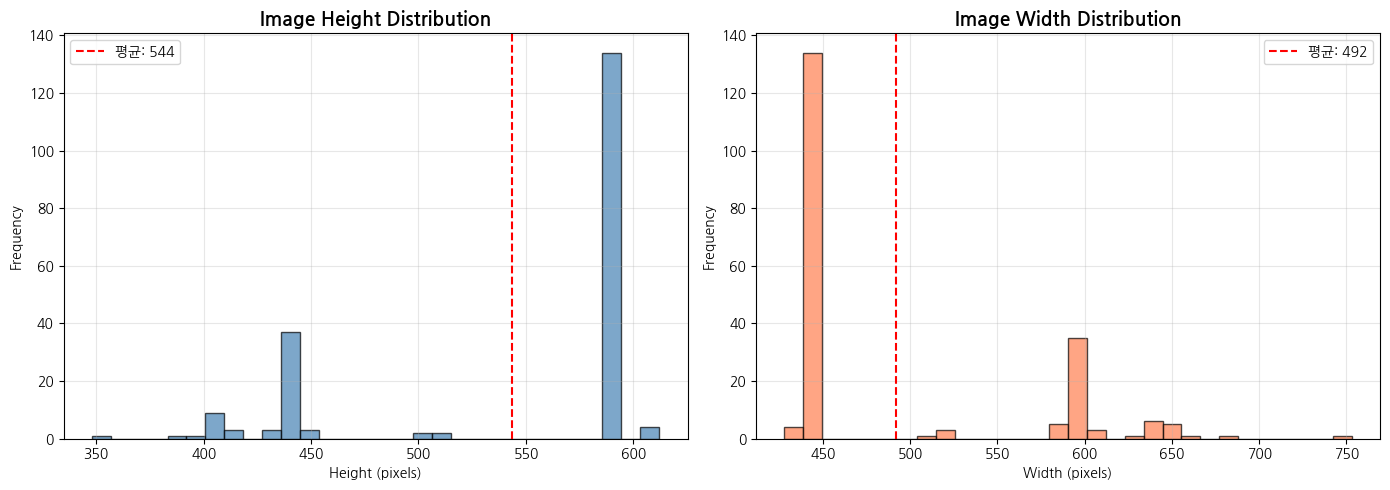

✅ 이미지 크기 분포 저장: eda_image_size.png


In [9]:
# ============================
# 이미지 크기 분석
# ============================
print("\n" + "="*80)
print("📐 이미지 크기 분석 (샘플 200개)")
print("="*80)

sizes = []
sample_df = train_df.sample(200, random_state=42)

for img_id in tqdm(sample_df['ID'], desc="이미지 크기 확인"):
    img_path = f"train/{img_id}"
    if os.path.exists(img_path):
        img = cv2.imread(img_path)
        if img is not None:
            h, w = img.shape[:2]
            sizes.append((h, w))

heights, widths = zip(*sizes)

print(f"\n높이:")
print(f"  - 최소: {min(heights)}px")
print(f"  - 최대: {max(heights)}px")
print(f"  - 평균: {np.mean(heights):.0f}px")
print(f"  - 중앙값: {np.median(heights):.0f}px")

print(f"\n너비:")
print(f"  - 최소: {min(widths)}px")
print(f"  - 최대: {max(widths)}px")
print(f"  - 평균: {np.mean(widths):.0f}px")
print(f"  - 중앙값: {np.median(widths):.0f}px")

# 시각화
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(heights, bins=30, color='steelblue', alpha=0.7, edgecolor='black')
axes[0].axvline(np.mean(heights), color='r', linestyle='--', label=f'평균: {np.mean(heights):.0f}')
axes[0].set_title('Image Height Distribution', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Height (pixels)')
axes[0].set_ylabel('Frequency')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].hist(widths, bins=30, color='coral', alpha=0.7, edgecolor='black')
axes[1].axvline(np.mean(widths), color='r', linestyle='--', label=f'평균: {np.mean(widths):.0f}')
axes[1].set_title('Image Width Distribution', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Width (pixels)')
axes[1].set_ylabel('Frequency')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
#plt.savefig('eda_image_size.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 이미지 크기 분포 저장: eda_image_size.png")


In [10]:
# ============================
# 잘못된 Label 검출 (수동 확인 필요)
# ============================
print("\n⚠️ 의심스러운 이미지 (수동 확인 필요):")

suspicious = {
    "45f0d2dfc7e47c03.jpg": 7,
    "aec62dced7af97cd.jpg": 14,
    "0583254a73b48ece.jpg": 10,
    "1ec14a14bbe633db.jpg": 7,
    "c5182ab809478f12.jpg": 14,
    "8646f2c3280a4f49.jpg": 3
}

for img_id, correct_label in suspicious.items():
    if img_id in train_df['ID'].values:
        current_label = train_df[train_df['ID'] == img_id]['target'].values[0]
        print(f"  - {img_id}: {current_label} → {correct_label}")


⚠️ 의심스러운 이미지 (수동 확인 필요):
  - 45f0d2dfc7e47c03.jpg: 3 → 7
  - aec62dced7af97cd.jpg: 3 → 14
  - 0583254a73b48ece.jpg: 11 → 10
  - 1ec14a14bbe633db.jpg: 14 → 7
  - c5182ab809478f12.jpg: 4 → 14
  - 8646f2c3280a4f49.jpg: 7 → 3



🔍 잘못된 Label 검출

⚠️ 수정 필요한 Label: 6개
  - 45f0d2dfc7e47c03.jpg
    현재: 3 (confirmation_of_admission_and_discharge)
    수정: 7 (medical_outpatient_certificate)
  - aec62dced7af97cd.jpg
    현재: 3 (confirmation_of_admission_and_discharge)
    수정: 14 (statement_of_opinion)
  - 0583254a73b48ece.jpg
    현재: 11 (pharmaceutical_receipt)
    수정: 10 (payment_confirmation)
  - 1ec14a14bbe633db.jpg
    현재: 14 (statement_of_opinion)
    수정: 7 (medical_outpatient_certificate)
  - c5182ab809478f12.jpg
    현재: 4 (diagnosis)
    수정: 14 (statement_of_opinion)
  - 8646f2c3280a4f49.jpg
    현재: 7 (medical_outpatient_certificate)
    수정: 3 (confirmation_of_admission_and_discharge)


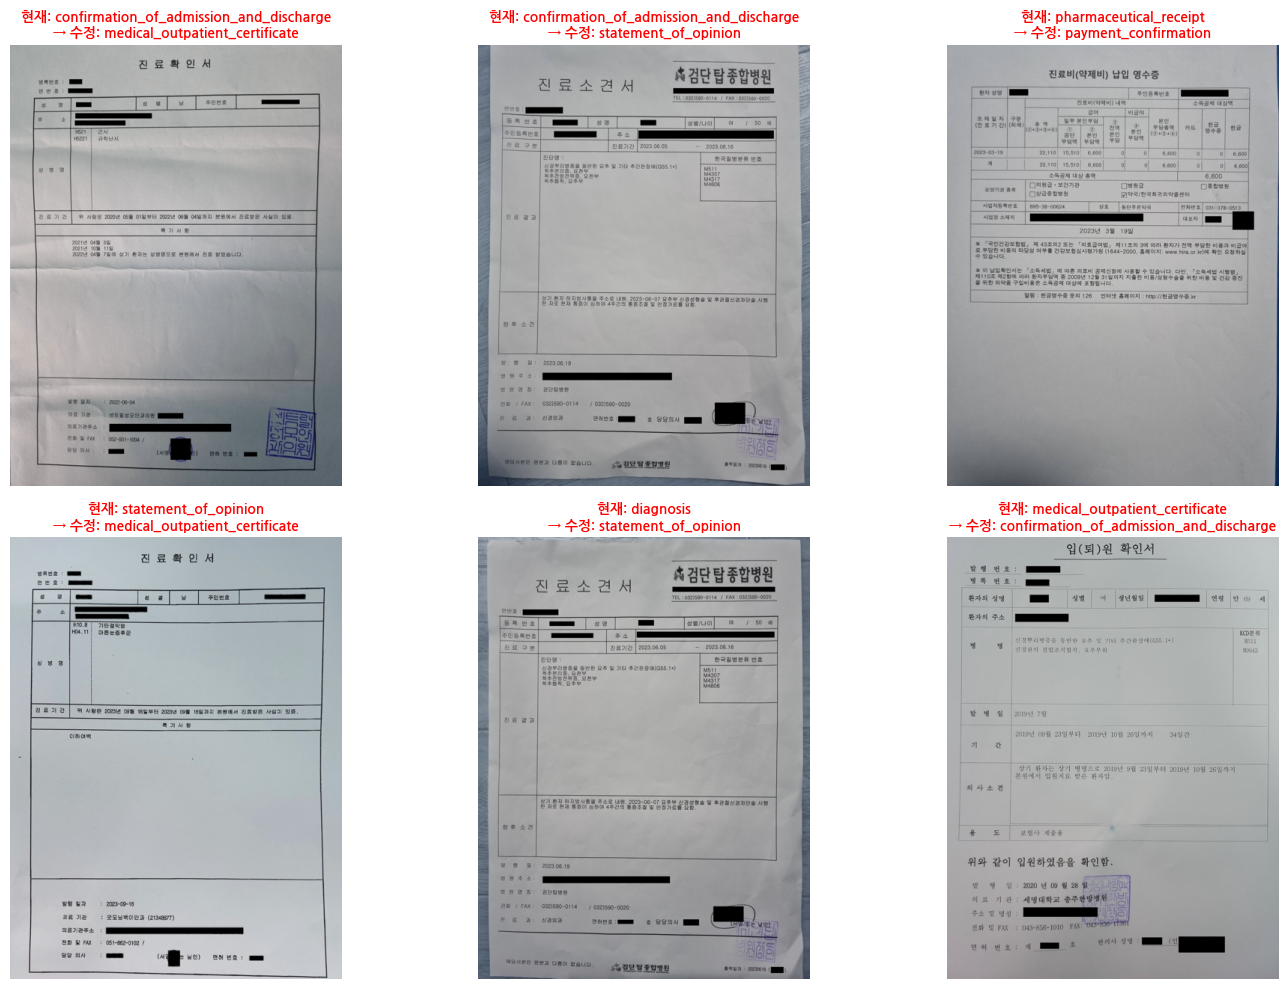


✅ 잘못된 Label 시각화 저장: eda_wrong_labels.png


In [11]:
# ============================
# 잘못된 Label 검출
# ============================
print("\n" + "="*80)
print("🔍 잘못된 Label 검출")
print("="*80)

# 전 기수가 발견한 잘못된 label
corrections = {
    "45f0d2dfc7e47c03.jpg": 7,
    "aec62dced7af97cd.jpg": 14,
    "0583254a73b48ece.jpg": 10,
    "1ec14a14bbe633db.jpg": 7,
    "c5182ab809478f12.jpg": 14,
    "8646f2c3280a4f49.jpg": 3
}

print(f"\n⚠️ 수정 필요한 Label: {len(corrections)}개")
for img_id, correct_label in corrections.items():
    if img_id in train_df['ID'].values:
        current_label = train_df[train_df['ID'] == img_id]['target'].values[0]
        print(f"  - {img_id}")
        print(f"    현재: {current_label} ({class_names[current_label]})")
        print(f"    수정: {correct_label} ({class_names[correct_label]})")
    else:
        print(f"  - {img_id}: 파일 없음")

# 시각화 (수정 전/후)
if all(img_id in train_df['ID'].values for img_id in corrections.keys()):
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    axes = axes.flatten()
    
    for idx, (img_id, correct_label) in enumerate(corrections.items()):
        img_path = f"train/{img_id}"
        if os.path.exists(img_path):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            current_label = train_df[train_df['ID'] == img_id]['target'].values[0]
            
            axes[idx].imshow(img)
            axes[idx].set_title(
                f"현재: {class_names[current_label]}\n→ 수정: {class_names[correct_label]}", 
                fontsize=10, fontweight='bold', color='red'
            )
            axes[idx].axis('off')
    
    plt.tight_layout()
    #plt.savefig('eda_wrong_labels.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✅ 잘못된 Label 시각화 저장: eda_wrong_labels.png")



📄 Baseline 제출 파일 분석 (highest.csv)

기본 정보:
  - 예측 수: 3140개
  - 컬럼: ['ID', 'target']

예측 클래스 분포:
   0: account_number                           -  201개 ( 6.40%)
   1: application_for_payment_of_pregnancy_medical_expenses -   90개 ( 2.87%)
   2: car_dashboard                            -  199개 ( 6.34%)
   3: confirmation_of_admission_and_discharge  -  187개 ( 5.96%)
   4: diagnosis                                -  191개 ( 6.08%)
   5: driver_lisence                           -  200개 ( 6.37%)
   6: medical_bill_receipts                    -  203개 ( 6.46%)
   7: medical_outpatient_certificate           -  207개 ( 6.59%)
   8: national_id_card                         -  200개 ( 6.37%)
   9: passport                                 -  200개 ( 6.37%)
  10: payment_confirmation                     -  205개 ( 6.53%)
  11: pharmaceutical_receipt                   -  192개 ( 6.11%)
  12: prescription                             -  200개 ( 6.37%)
  13: resume                                   -  151개 ( 4.

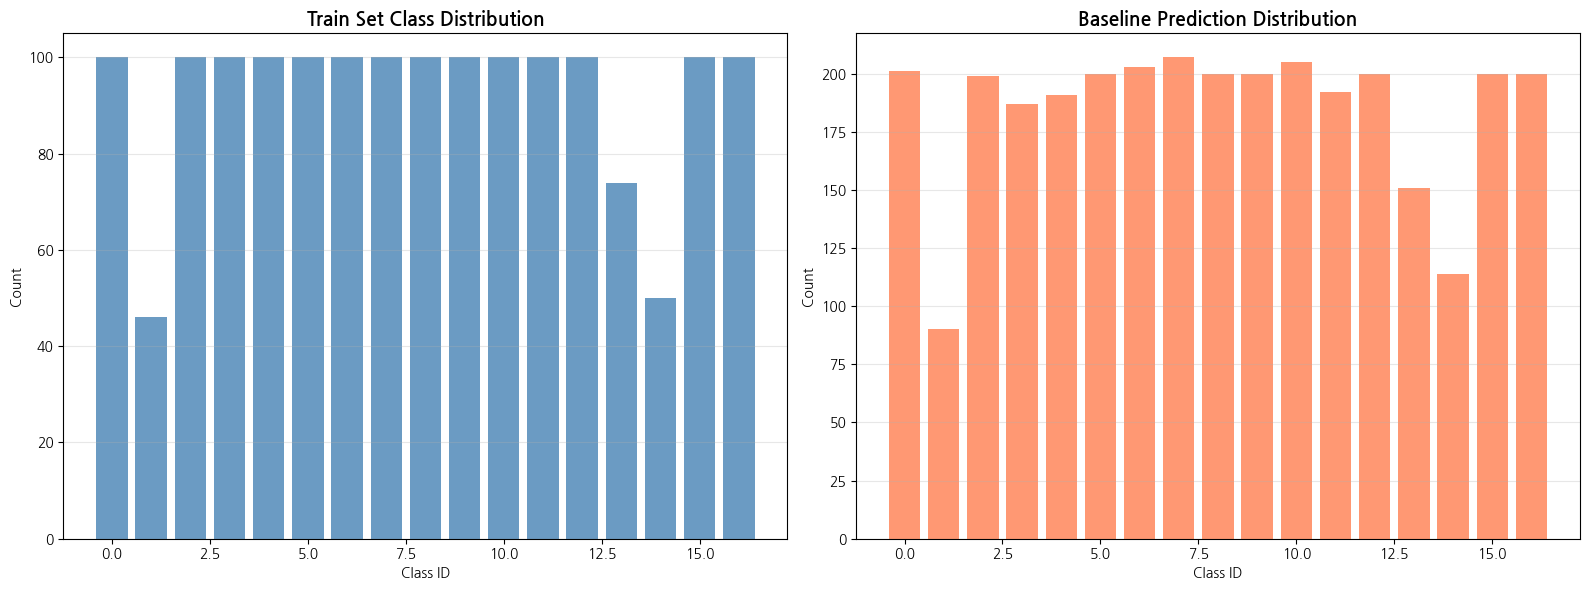


✅ Baseline 비교 저장: eda_baseline_comparison.png

📊 분포 통계 비교:
항목                   Train           Baseline       
--------------------------------------------------
평균                   92.4            184.7          
표준편차                 17.8            33.8           
최소                   46              90             
최대                   100             207            


In [12]:
# ============================
# Baseline CSV 분석
# ============================
if os.path.exists('submission_single_efficientb4_tta.csv'):
    print("\n" + "="*80)
    print("📄 Baseline 제출 파일 분석 (highest.csv)")
    print("="*80)
    
    baseline_df = pd.read_csv('submission_single_efficientb4_tta.csv')
    
    print(f"\n기본 정보:")
    print(f"  - 예측 수: {len(baseline_df)}개")
    print(f"  - 컬럼: {list(baseline_df.columns)}")
    
    # 예측 분포
    pred_counts = baseline_df['target'].value_counts().sort_index()
    
    print(f"\n예측 클래스 분포:")
    for target in pred_counts.index:
        count = pred_counts[target]
        name = class_names.get(target, f"Unknown-{target}")
        print(f"  {target:2d}: {name:40s} - {count:4d}개 ({count/len(baseline_df)*100:5.2f}%)")
    
    # Train vs Baseline 분포 비교
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    # Train 분포
    axes[0].bar(class_counts.index, class_counts.values, color='steelblue', alpha=0.8)
    axes[0].set_title('Train Set Class Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Class ID')
    axes[0].set_ylabel('Count')
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Baseline 예측 분포
    axes[1].bar(pred_counts.index, pred_counts.values, color='coral', alpha=0.8)
    axes[1].set_title('Baseline Prediction Distribution', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Class ID')
    axes[1].set_ylabel('Count')
    axes[1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    #plt.savefig('eda_baseline_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print("\n✅ Baseline 비교 저장: eda_baseline_comparison.png")
    
    # 통계 비교
    print(f"\n📊 분포 통계 비교:")
    print(f"{'항목':<20} {'Train':<15} {'Baseline':<15}")
    print("-"*50)
    print(f"{'평균':<20} {class_counts.mean():<15.1f} {pred_counts.mean():<15.1f}")
    print(f"{'표준편차':<20} {class_counts.std():<15.1f} {pred_counts.std():<15.1f}")
    print(f"{'최소':<20} {class_counts.min():<15} {pred_counts.min():<15}")
    print(f"{'최대':<20} {class_counts.max():<15} {pred_counts.max():<15}")
    
else:
    print("\n💡 highest.csv 파일이 없습니다.")



🔄 데이터 증강 효과 예측


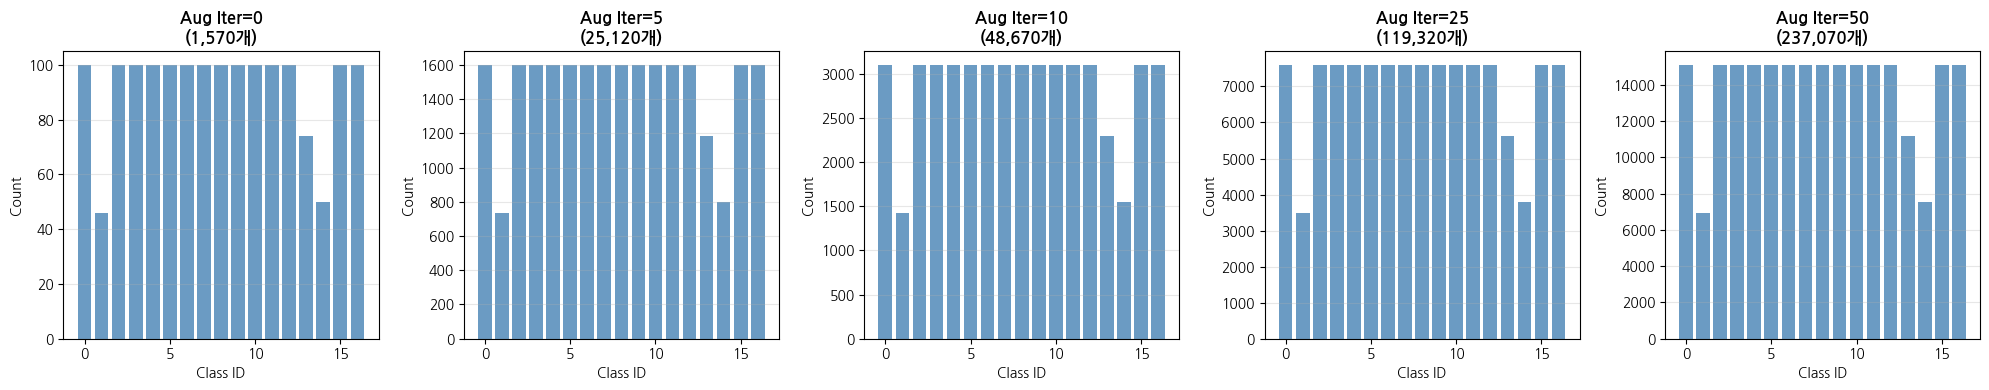

✅ 증강 효과 예측 저장: eda_augmentation_effect.png

💡 증강 배수별 총 이미지 수:
  - Aug Iter= 0:   1,570개 (x  1.0)
  - Aug Iter= 5:  25,120개 (x 16.0)
  - Aug Iter=10:  48,670개 (x 31.0)
  - Aug Iter=25: 119,320개 (x 76.0)
  - Aug Iter=50: 237,070개 (x151.0)


In [13]:
# ============================
# 증강 후 예상 분포
# ============================
print("\n" + "="*80)
print("🔄 데이터 증강 효과 예측")
print("="*80)

aug_iters = [0, 5, 10, 25, 50]
fig, axes = plt.subplots(1, len(aug_iters), figsize=(20, 4))

for idx, aug_iter in enumerate(aug_iters):
    total_per_image = 1 + aug_iter * 3  # 원본 + (Aup+Alb, Alb, Aup)
    augmented_counts = class_counts * total_per_image
    
    axes[idx].bar(augmented_counts.index, augmented_counts.values, 
                  color='steelblue', alpha=0.8)
    axes[idx].set_title(f'Aug Iter={aug_iter}\n({augmented_counts.sum():,}개)', 
                        fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Class ID')
    axes[idx].set_ylabel('Count')
    axes[idx].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
#plt.savefig('eda_augmentation_effect.png', dpi=150, bbox_inches='tight')
plt.show()

print("✅ 증강 효과 예측 저장: eda_augmentation_effect.png")

print(f"\n💡 증강 배수별 총 이미지 수:")
for aug_iter in aug_iters:
    total = len(train_df) * (1 + aug_iter * 3)
    print(f"  - Aug Iter={aug_iter:2d}: {total:7,}개 (x{total/len(train_df):5.1f})")


In [14]:
# ============================
# EDA 요약
# ============================
print("\n" + "="*80)
print("📋 EDA 요약")
print("="*80)

print(f"\n✅ 데이터 기본 정보:")
print(f"  - 학습 데이터: {len(train_df):,}개")
print(f"  - 클래스 수: {len(class_names)}개")
print(f"  - 평균 이미지 크기: {np.mean(heights):.0f}x{np.mean(widths):.0f}px")

print(f"\n⚠️ 주의 사항:")
print(f"  - 불균형 클래스: {len(minority_classes)}개 (100개 미만)")
print(f"  - 잘못된 Label: {len(corrections)}개")
print(f"  - 최소/최대 클래스 비율: {class_counts.min()}:{class_counts.max()} (1:{class_counts.max()/class_counts.min():.1f})")

print(f"\n💡 권장 사항:")
print(f"  - Label 수정 필수")
print(f"  - 데이터 증강으로 불균형 완화 (권장: Aug Iter=25~50)")
print(f"  - 이미지 크기: 380x380 or 384x384 권장")

print("\n✅ 생성된 파일:")
print("  - eda_class_distribution.png")
print("  - eda_image_size.png")
print("  - eda_class_samples.png")
print("  - eda_wrong_labels.png")
print("  - eda_baseline_comparison.png")
print("  - eda_augmentation_effect.png")



📋 EDA 요약

✅ 데이터 기본 정보:
  - 학습 데이터: 1,570개
  - 클래스 수: 17개
  - 평균 이미지 크기: 544x492px

⚠️ 주의 사항:
  - 불균형 클래스: 3개 (100개 미만)
  - 잘못된 Label: 6개
  - 최소/최대 클래스 비율: 46:100 (1:2.2)

💡 권장 사항:
  - Label 수정 필수
  - 데이터 증강으로 불균형 완화 (권장: Aug Iter=25~50)
  - 이미지 크기: 380x380 or 384x384 권장

✅ 생성된 파일:
  - eda_class_distribution.png
  - eda_image_size.png
  - eda_class_samples.png
  - eda_wrong_labels.png
  - eda_baseline_comparison.png
  - eda_augmentation_effect.png


Index: 428, Image ID: 45f0d2dfc7e47c03.jpg
Label Number: 3


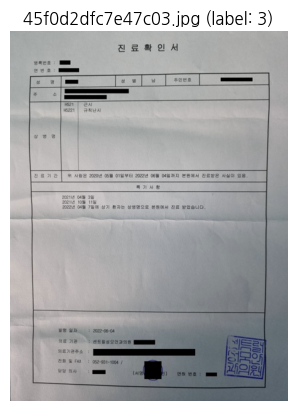

Index: 1095, Image ID: aec62dced7af97cd.jpg
Label Number: 3


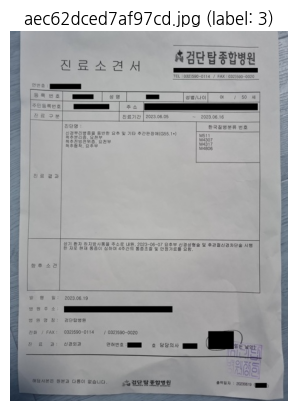

Index: 862, Image ID: 8646f2c3280a4f49.jpg
Label Number: 7


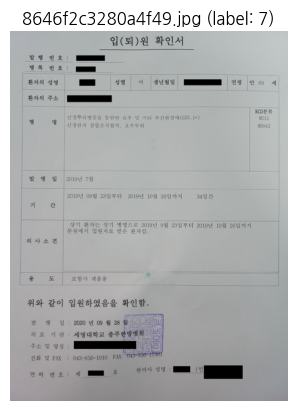

Index: 192, Image ID: 1ec14a14bbe633db.jpg
Label Number: 14


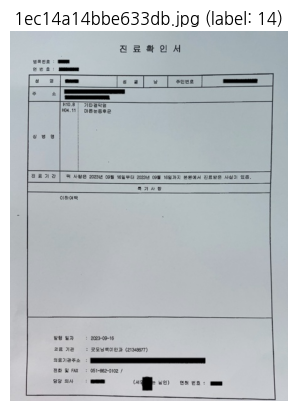

Index: 1237, Image ID: c5182ab809478f12.jpg
Label Number: 4


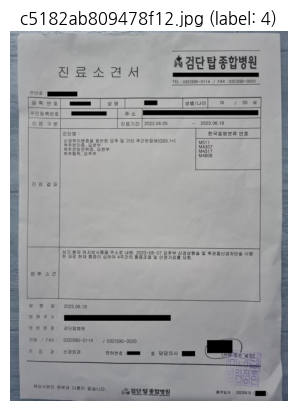

Index: 38, Image ID: 0583254a73b48ece.jpg
Label Number: 11


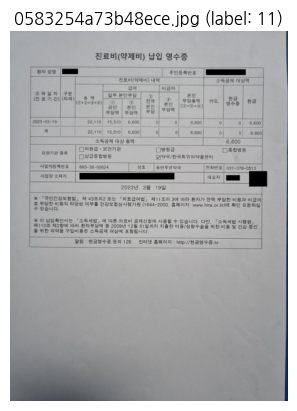

Index: 340, Image ID: 38d1796b6ad99ddd.jpg
Label Number: 11


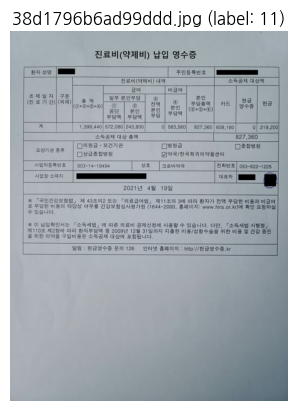

In [15]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import os

# train.csv 데이터 불러오기
train_df = pd.read_csv("train.csv")

# 확인할 인덱스 목록
indices_to_check = [428, 1095, 862, 192, 1237, 38, 340]

# 이미지 폴더 경로 (환경에 따라 수정)
img_folder = "train"

for idx in indices_to_check:
    row = train_df.iloc[idx]
    img_id = row['ID']
    label_num = row['target']

    print(f"Index: {idx}, Image ID: {img_id}")
    print(f"Label Number: {label_num}")

    img_path = os.path.join(img_folder, img_id)
    img = cv2.imread(img_path)

    if img is None:
        print(f"이미지 파일을 찾을 수 없습니다: {img_path}\n")
        continue

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    plt.imshow(img_rgb)
    plt.title(f"{img_id} (label: {label_num})")
    plt.axis('off')
    plt.show()
